# Статистика, DS-поток
## Практическое задание 14


**Правила:**

* Дедлайн **18 декабря 16:00**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ad21_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 &mdash; 8 баллов.

**Важность задач:**

* *средняя:* задача 1.

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as sps

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
%matplotlib inline

import plotly
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

sns.set(font_scale=1.7, style='whitegrid', palette='Set2')

from tqdm.notebook import tqdm
from time import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
%ls
%cd 'gdrive/MyDrive/DS/task14'

data.csv  task14.html  task14.ipynb
/bin/bash: line 0: cd: gdrive/MyDrive/DS/task14: No such file or directory


In [36]:
! jupyter nbconvert --to html 'task14.ipynb'

[NbConvertApp] Converting notebook task14.ipynb to html
[NbConvertApp] Writing 1212824 bytes to task14.html


## Задача 1.

При решении задачи классификаци, как и обсуждалось на занятии, нам часто требуется помимо метки класса предсказать еще и вероятность принадлежности соответствующему классу. Использование оценок вероятностей дает некоторую гибкость при решении задачи, ведь мы оставляем за собой право на то, как именно интепретировать эти оценки вероятности. Например, мы можем легко поменять порог для бинарной классификации и получить некоторый прирост по целевым метриками. 

При использовании моделей, которые предсказывают вероятности, хотелось, чтобы оценки вероятностей хорошо оценивали сами вероятности. Другими словами, если мы рассмотрим множество объектов, для которых $\sigma(\theta^Tx) \approx 0.8$, то разумно ожидать, что около $80\%$ из этих рассмотренных объектов действительно имеют положительную метку. Существуют некоторые методы для оценки того, насколько хорошо скалибрована модель, а также средства для калибровки оценок вероятностей. 

Как понять, явлется ли модель скалиброванной? Для этого можно посмотреть на:

* Калибровочные кривые.  При построении графика мы сопоставляем истинную частоту положительной метки с ее оценкой вероятностью. 

* Гистограммы для распределения оценок вероятностей.  

Рассмотрим пример из [sklearn](https://scikit-learn.org/stable/modules/calibration.html#calibration).

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_compare_calibration_001.png)

На первом графике изображены калибровочные кривые. По оси Y нанесены истинные частоты положительного класса, а по оси X &mdash; средняя оценка вероятности. На графике также можно заметить линию, которая изображает идеально-скалиброванную модель.

На графиках ниже изображены гистограммы значений предсказанных оценок вероятности для разных моделей.

Не будем говорить о поведении двух моделей (SVC и RandomFores), т.к. их изучением мы займемся весной. Рассмотрим поведение логистической регрессии и Naive Bayes. Можно заметить,что прогнозы для логистической регрессии оказываются достаточно хорошо-скалиброванными, в то время как NaiveBayes иногда имеет слишком завышенный или, наоборот, заниженный прогноз. Подобное поведение может оказаться критичным, например, в задаче кредитного скоринга, где недооценка рисков может привести к потере средств.

Существует некоторое количество методов для калибровки. Наиболее простым методом считается гистограммная
калибровка. Рассмотрим ее чуть подробнее. Разобьем отрезок $[0, 1]$ на бакеты $B_1, \ldots, B_K$ и каждому бакету поставим в соответствие число $\theta_j$.
Тогда, если модель для объекта $x$ оценила вероятность его принадлежности положительному классу как $\widehat{p}(x)$, то в качестве итоговой оценки вероятности возьмем $\theta_j$ для такого $j$, что выполнено $\widehat{p}(x) \in B_j$. Параметры $\theta_j$ оценим по калибровочной выборке как долю объектов положительного класса среди тех, для которых $\widehat{p}(x) \in B_j$.

Про методы калибровки, реализованные в `sklearn` можно прочить [здесь](https://scikit-learn.org/stable/modules/calibration.html#calibration).

Посмотрим на калибровку на простом примере. Загрузите заранее сгенерированные данные из файла `data.csv`.

In [ ]:
data = pd.read_csv("data.csv")
data.sample(7)

,feature_0,feature_1,target
13089,-0.074863,2.527754,1
18830,0.826521,-0.261209,0
3416,1.332271,-0.925907,0
10292,-1.504028,0.442706,1
12815,-3.948099,-0.833992,1
2665,-0.348996,1.906571,0
7810,0.191349,-0.004420,0


Визуализируйте загруженные данные выборку.

In [ ]:
data_1.feature_1

1        5.777539
2        1.885675
6        2.686353
7       -2.769245
10       1.586907
           ...   
19988    0.394384
19989   -4.129027
19991   -1.971813
19996   -1.118619
19999   -3.369763
Name: feature_1, Length: 7687, dtype: float64

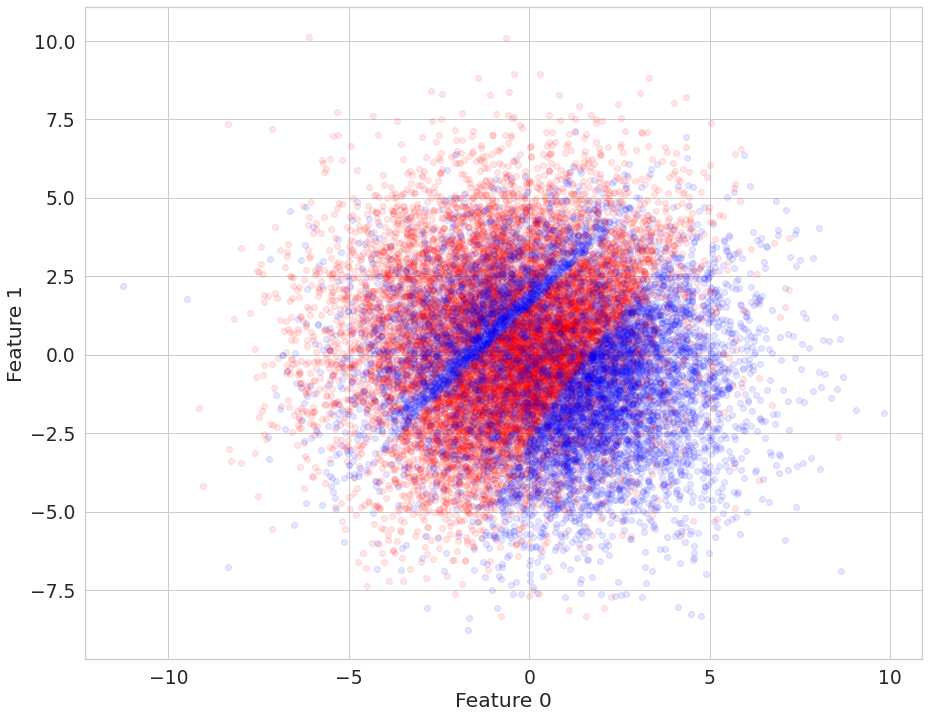

In [20]:
plt.figure(figsize=(15, 12))

data_0 = data[data.target == 0]
data_1 = data[data.target == 1]

plt.scatter(data_0.feature_0, data_0.feature_1, color='r', alpha=0.1)
plt.scatter(data_1.feature_0, data_1.feature_1, color='b', alpha=0.1)

plt.xlabel('Feature 0')
plt.ylabel('Feature 1')

plt.show()

Видно пару интересных синих прямых, данные не совсем случайные (хотя в целом похожи на нормальные)

**1.** Для начала проверим линейность логита. Опишите процедуру проверки линейности логита в логистической регрессии с помощью сглаженных диаграмм рассеяния.

**Ответ:** 
Глянем на слайд с лекции

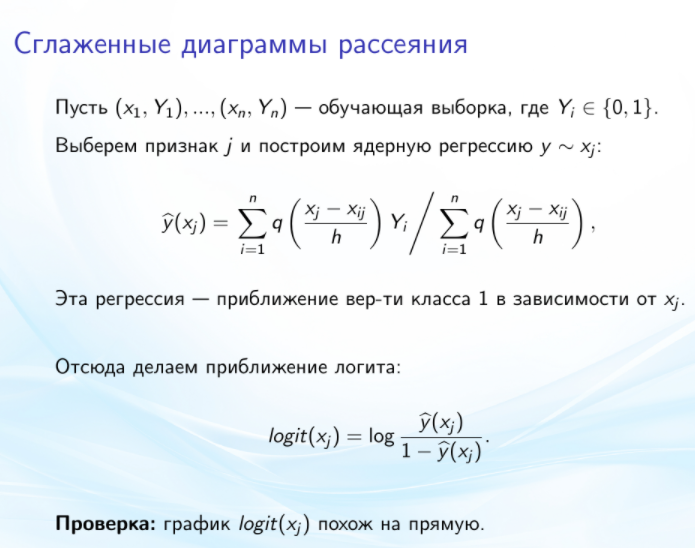

Т.е. нам нужно сделать ядерную регрессию для текущего случая, а затем проверить, что это похоже на прямую

Реализуем эту процедуру для сгенерированных данных.

In [26]:
a = np.arange(5).reshape((1, 5))
b = np.arange(6).reshape((6, 1))
a - b

ValueError: ignored

In [22]:
X, Y = data[['feature_0', 'feature_1']], data['target']

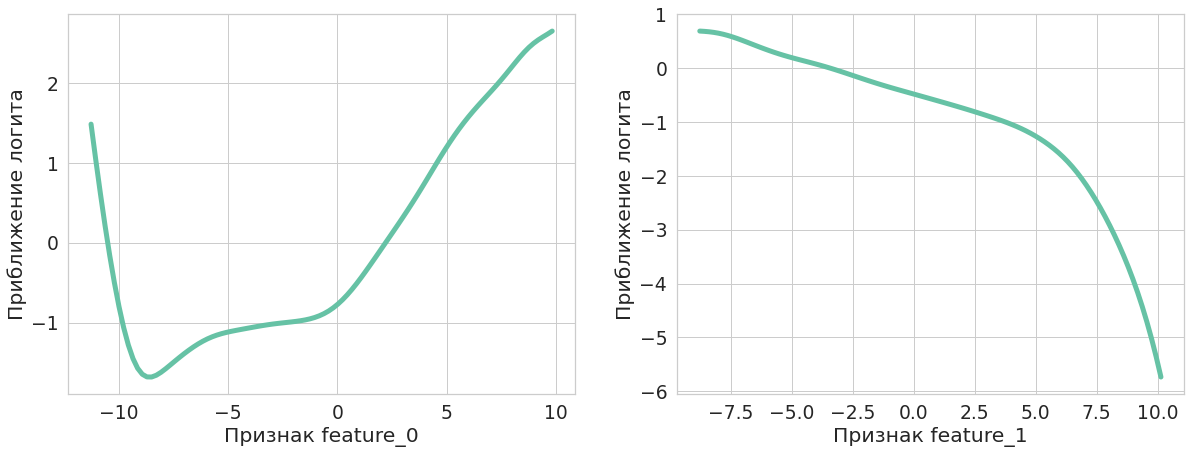

In [30]:
h = 1  # ширина ядра

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
# цикл по признакам
for feature, ax in zip(X.columns, axs):
    f_values = X[feature].to_numpy()

    # отсортированная сетка по признаку feature
    # для построения ядерной оценки
    x_grid = np.linspace(f_values.min(), f_values.max(), 100)

    # гауссовское ядро с шириной h
    kernel = lambda x: sps.norm.pdf(x / h)

    # значения ядра в точках выборки
    kernel_values = kernel(x_grid.reshape((1, -1)) - f_values.reshape((-1, 1)))

    # оценка по ядерной регрессии для признака feature_idx
    y_est = Y @ kernel_values / kernel_values.sum(axis=0)

    # приближение логита по оценкам y_est
    l_sm = np.log(y_est / (1 - y_est))
    
    # отрисуем графики
    ax.plot(x_grid, l_sm, lw=5)
    ax.set_xlabel(f'Признак {feature}')
    ax.set_ylabel('Приближение логита')
plt.show()

Что можно сказать по получившимся графикам?

**Ответ:** мало того, что зависимость не линейная, так еще и классы (к сожалению) не будут линейно разделимы

**2.** Разделите выборку на тестовую и обучающую, параметр `test_size` установите равным 0.3, а `random_state = 42`.

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.3, random_state=42)

Из обучающей выборки выделите половину данных для дальнейшей калибровки. Ответьте, почему следует сделать так, а не использовать для калибровки обучающую выборку? 

In [32]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, train_size=0.5, random_state=42)

Определите модель логистической регресии без регуляризации и обучите ее. 

Обратите внимание на параметр `penalty`, по умолчанию там стоит `l2`, в параметр `solver` передайте `'saga'`.

In [33]:
model = LogisticRegression(
    solver='saga',
    penalty='none',
).fit(
    X_train, 
    Y_train,
)

proba = model.predict_proba(X_valid)[:, -1]

In [34]:
proba

array([0.37534238, 0.35282933, 0.65351627, ..., 0.23139721, 0.3197462 ,
       0.17233765])

Постройте для модели логистической регрессии калибровочную кривую. Вам поможет [`CalibrationDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibrationDisplay.html). Используйте достаточно большое значенение для параметра `n_bins` (например около 30).


In [ ]:
<...>

**3.** Реализуйте гистограммную калибровку и примените ее к нашим данным. Изобразите калибровочные кривые. Что можно сказать о результате?

При реализации вам могут помочь функции `np.digitize`, `np.bincount`, `np.unique`.

In [ ]:
<..>

**Вывод:** <...>